<a href="https://colab.research.google.com/github/john-d-noble/callcenter/blob/main/Regime_Aware_Forecasting_Model_FINAL_PRODUCTION_VERSION.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Regime-Aware Forecasting Model - FINAL PRODUCTION VERSION

## Overview
This notebook builds a smart forecasting tool for daily call volumes. It detects 'regimes' (stable periods of high or low activity), creates features from the data, trains multiple ML models to predict future calls, picks the best one, and shows forecasts with uncertainty bands and explanations.

In very simple terms, the whole process:
1. **Load Data:** Get daily call volumes and market info (like stock prices).
2. **Find Regimes:** Spot periods where call patterns are steady but different (e.g., busy seasons).
3. **Build Features:** Create helpful inputs for models, like past calls or weekend flags.
4. **Train Models:** Test 3 models (XGBoost, Random Forest, Ridge) on historical data.
5. **Pick Winner & Forecast:** Choose the best model, predict future calls with confidence intervals.
6. **Explain Results:** Use SHAP to show why the model makes certain predictions.

**Key Config:** We're forecasting 'daily' calls (could switch to 'weekly'). Data covers ~2 years up to early September 2025.

In [5]:
import pandas as pd
import numpy as np
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Machine Learning
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error
import xgboost as xgb

# Visualization and Analysis
import matplotlib.pyplot as plt
import seaborn as sns

# --- GLOBAL CONFIGURATION ---
FORECAST_HORIZON = 'weekly'  # Options: 'daily', 'weekly'
# --------------------------

print("✅ All dependencies loaded successfully!")
print(f"🎯 Forecast Horizon Set To: {FORECAST_HORIZON.upper()}")


✅ All dependencies loaded successfully!
🎯 Forecast Horizon Set To: WEEKLY


In [6]:
# SECTION 2: REGIME DETECTION
def load_full_dataset(filepath: str = 'enhanced_eda_data.csv') -> pd.DataFrame:
    """
    Loads the full dataset including market data columns.

    In simple terms:
    - Read CSV, fix date column, sort by time
    - Drop first/last rows (often incomplete)
    - Fill market data gaps

    Returns:
        Clean DataFrame with 'date' and 'calls' ready
    """
    print("📄 Loading full dataset with market data...")

    try:
        df = pd.read_csv(filepath)

        # Fix date column
        if 'Date' in df.columns:
            df = df.rename(columns={'Date': 'date'})
        df['date'] = pd.to_datetime(df['date'])

        # Sort and reset
        df = df.sort_values('date').reset_index(drop=True)

        # Drop edges (incomplete periods)
        df = df.iloc[1:-1].reset_index(drop=True)

        # Check required column
        if 'calls' not in df.columns:
            raise KeyError("'calls' column is missing.")

        # Fill market data gaps (weekends)
        market_cols = [c for c in df.columns if c not in ['date', 'calls']]
        df[market_cols] = df[market_cols].ffill().bfill()

        print(f"✔ Loaded {len(df)} days from {df['date'].min().date()} to {df['date'].max().date()}")
        return df

    except Exception as e:
        print(f"❌ Error loading data: {e}")
        raise

# Load data
df_production = load_full_dataset()


📄 Loading full dataset with market data...
✔ Loaded 976 days from 2023-01-02 to 2025-09-03


In [7]:
# SECTION 3: REGIME DETECTION
def detect_regimes(df: pd.DataFrame, window: int = 30) -> pd.DataFrame:
    """
    Detects market regimes using rolling statistics.
    """
    df_regimes = df.copy()

    # Calculate rolling statistics
    df_regimes['rolling_mean'] = df_regimes['calls'].rolling(window, center=True).mean()
    df_regimes['rolling_std'] = df_regimes['calls'].rolling(window, center=True).std()

    # Define regimes based on mean
    median_calls = df_regimes['rolling_mean'].median()
    df_regimes['regime'] = 'normal'
    df_regimes.loc[df_regimes['rolling_mean'] > median_calls * 1.1, 'regime'] = 'high'
    df_regimes.loc[df_regimes['rolling_mean'] < median_calls * 0.9, 'regime'] = 'low'

    # Fill NaN values
    df_regimes['regime'].fillna('normal', inplace=True)

    print(f"✓ Detected regimes: {df_regimes['regime'].value_counts().to_dict()}")
    return df_regimes

# Apply regime detection
df_with_regimes = detect_regimes(df_production)

# FEATURE ENGINEERING SECTION
def create_features(df: pd.DataFrame, horizon: str = 'daily') -> pd.DataFrame:
    """
    Creates features for forecasting.
    """
    print("\n🔧 FEATURE ENGINEERING")
    print("-" * 50)

    features = pd.DataFrame()
    features['target'] = df['calls'].values

    # Lag features
    for lag in [1, 2, 3, 7, 14, 21, 28]:
        features[f'lag_{lag}'] = df['calls'].shift(lag)

    # Rolling statistics
    for window in [7, 14, 28]:
        features[f'rolling_mean_{window}'] = df['calls'].rolling(window).mean().shift(1)
        features[f'rolling_std_{window}'] = df['calls'].rolling(window).std().shift(1)

    # Date features
    features['day_of_week'] = pd.to_datetime(df['date']).dt.dayofweek
    features['month'] = pd.to_datetime(df['date']).dt.month
    features['quarter'] = pd.to_datetime(df['date']).dt.quarter
    features['is_weekend'] = (features['day_of_week'] >= 5).astype(int)

    # Regime features (if available)
    if 'regime' in df.columns:
        features['regime_high'] = (df['regime'] == 'high').astype(int)
        features['regime_low'] = (df['regime'] == 'low').astype(int)

    # Market features (if available)
    market_cols = [c for c in df.columns if c not in ['date', 'calls', 'regime', 'rolling_mean', 'rolling_std']]
    for col in market_cols[:5]:  # Limit to first 5 market features
        if col in df.columns:
            features[f'market_{col}'] = df[col].values

    print(f"✓ Created {features.shape[1]} features")
    print(f"✓ Dataset shape: {features.shape}")

    return features

# Create features
features_df = create_features(df_with_regimes, FORECAST_HORIZON)

✓ Detected regimes: {'normal': 437, 'high': 313, 'low': 226}

🔧 FEATURE ENGINEERING
--------------------------------------------------
✓ Created 25 features
✓ Dataset shape: (976, 25)


In [8]:
#==============================================================================
# SECTIONS 4-6: COMPLETE CV, TRAINING, AND MODEL SELECTION
#==============================================================================

# SECTION 4: TIME SERIES CROSS-VALIDATION
def time_series_cross_validation(df_features: pd.DataFrame, df_dates: pd.DataFrame,
                                 n_splits: int = 3, test_days: int = 30) -> list:
    """
    Creates multiple train/test splits for robust evaluation.
    """
    print("\n🔄 TIME SERIES CROSS-VALIDATION")
    print("-" * 50)

    clean_df = df_features.iloc[28:].copy().reset_index(drop=True)
    clean_dates = df_dates['date'].iloc[28:].reset_index(drop=True)

    splits = []
    feature_cols = [c for c in df_features.columns if c != 'target']

    for split_id in range(n_splits):
        test_end = len(clean_df) - (split_id * test_days)
        test_start = test_end - test_days

        if test_start < 90:
            break

        train_data = clean_df.iloc[:test_start]
        test_data = clean_df.iloc[test_start:test_end]

        split = {
            'split_id': split_id,
            'X_train': train_data[feature_cols],
            'y_train': train_data['target'],
            'X_test': test_data[feature_cols],
            'y_test': test_data['target'],
            'dates_train': clean_dates.iloc[:test_start],
            'dates_test': clean_dates.iloc[test_start:test_end]
        }

        splits.append(split)

        print(f"Split {split_id}: Train {split['dates_train'].iloc[0].date()} to {split['dates_train'].iloc[-1].date()}, "
              f"Test {split['dates_test'].iloc[0].date()} to {split['dates_test'].iloc[-1].date()}")

    print(f"✔ Created {len(splits)} validation splits")
    return splits

# SECTION 5: MODEL TRAINING WITH CV
def train_models_with_cv(splits: list) -> tuple:
    """
    Trains models across all CV splits and aggregates results.
    """
    print("\n🤖 MODEL TRAINING WITH CROSS-VALIDATION")
    print("=" * 80)

    model_configs = {
        'XGBoost': {
            'model_class': xgb.XGBRegressor,
            'params': {
                'max_depth': 4,
                'learning_rate': 0.1,
                'n_estimators': 100,
                'subsample': 0.8,
                'colsample_bytree': 0.8,
                'random_state': 42,
                'verbosity': 0
            },
            'use_scaled': False
        },
        'RandomForest': {
            'model_class': RandomForestRegressor,
            'params': {
                'n_estimators': 100,
                'max_depth': 8,
                'min_samples_split': 10,
                'min_samples_leaf': 5,
                'random_state': 42,
                'n_jobs': -1
            },
            'use_scaled': False
        },
        'Ridge': {
            'model_class': Ridge,
            'params': {
                'alpha': 10.0,
                'random_state': 42
            },
            'use_scaled': True
        }
    }

    cv_results = {name: {'mapes': [], 'maes': [], 'models': []}
                  for name in model_configs.keys()}

    for split in splits:
        print(f"\nProcessing Split {split['split_id']}...")

        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(split['X_train'])
        X_test_scaled = scaler.transform(split['X_test'])

        for name, config in model_configs.items():
            model = config['model_class'](**config['params'])

            if config['use_scaled']:
                X_train_use = X_train_scaled
                X_test_use = X_test_scaled
            else:
                X_train_use = split['X_train'].values
                X_test_use = split['X_test'].values

            model.fit(X_train_use, split['y_train'])
            predictions = np.maximum(model.predict(X_test_use), 0)

            mape = mean_absolute_percentage_error(split['y_test'], predictions) * 100
            mae = mean_absolute_error(split['y_test'], predictions)

            cv_results[name]['mapes'].append(mape)
            cv_results[name]['maes'].append(mae)
            cv_results[name]['models'].append(model)

            print(f"  {name}: MAPE={mape:.2f}%")

    print("\n📊 CROSS-VALIDATION SUMMARY")
    print("-" * 60)
    print(f"{'Model':<15} {'Mean MAPE':<12} {'Std MAPE':<12} {'Mean MAE'}")
    print("-" * 60)

    final_results = {}
    for name, results in cv_results.items():
        mean_mape = np.mean(results['mapes'])
        std_mape = np.std(results['mapes'])
        mean_mae = np.mean(results['maes'])

        final_results[name] = {
            'mean_mape': mean_mape,
            'std_mape': std_mape,
            'mean_mae': mean_mae,
            'best_model': results['models'][np.argmin(results['mapes'])],
            'all_models': results['models']
        }

        print(f"{name:<15} {mean_mape:>10.2f}% {std_mape:>10.2f}% {mean_mae:>10.1f}")

    return final_results, model_configs

# SECTION 6: BOOTSTRAP FORECAST FUNCTION
def generate_bootstrap_forecast(X_train, y_train, X_test, model_config, n_boots=20):
    """
    Generates forecast with confidence intervals using proper model parameters.
    """
    predictions_all = []

    for i in range(n_boots):
        sample_indices = np.random.choice(len(X_train), size=len(X_train), replace=True)
        X_sample = X_train.iloc[sample_indices] if hasattr(X_train, 'iloc') else X_train[sample_indices]
        y_sample = y_train.iloc[sample_indices] if hasattr(y_train, 'iloc') else y_train[sample_indices]

        boot_model = model_config['model_class'](**{**model_config['params'], 'random_state': i})

        if model_config['use_scaled']:
            scaler = StandardScaler()
            X_sample = scaler.fit_transform(X_sample)
            X_test_use = scaler.transform(X_test)
        else:
            X_test_use = X_test

        boot_model.fit(X_sample, y_sample)
        predictions_all.append(boot_model.predict(X_test_use))

    predictions_all = np.array(predictions_all)

    return (
        np.mean(predictions_all, axis=0),
        np.percentile(predictions_all, 10, axis=0),
        np.percentile(predictions_all, 90, axis=0)
    )

# NOW RUN EVERYTHING IN SEQUENCE
print("Starting complete cross-validation pipeline...")

# Run cross-validation
cv_splits = time_series_cross_validation(features_df, df_with_regimes, n_splits=3)

# Train models with CV
cv_results, model_configs = train_models_with_cv(cv_splits)

# Select best model
best_model_name = min(cv_results.keys(), key=lambda x: cv_results[x]['mean_mape'])
best_model_info = cv_results[best_model_name]

print(f"\n🏆 BEST MODEL: {best_model_name}")
print(f"   Mean MAPE: {best_model_info['mean_mape']:.2f}% ± {best_model_info['std_mape']:.2f}%")

Starting complete cross-validation pipeline...

🔄 TIME SERIES CROSS-VALIDATION
--------------------------------------------------
Split 0: Train 2023-01-30 to 2025-08-04, Test 2025-08-05 to 2025-09-03
Split 1: Train 2023-01-30 to 2025-07-05, Test 2025-07-06 to 2025-08-04
Split 2: Train 2023-01-30 to 2025-06-05, Test 2025-06-06 to 2025-07-05
✔ Created 3 validation splits

🤖 MODEL TRAINING WITH CROSS-VALIDATION

Processing Split 0...
  XGBoost: MAPE=6.07%
  RandomForest: MAPE=6.07%
  Ridge: MAPE=5.54%

Processing Split 1...
  XGBoost: MAPE=10.91%
  RandomForest: MAPE=8.61%
  Ridge: MAPE=9.46%

Processing Split 2...
  XGBoost: MAPE=7.65%
  RandomForest: MAPE=7.60%
  Ridge: MAPE=7.26%

📊 CROSS-VALIDATION SUMMARY
------------------------------------------------------------
Model           Mean MAPE    Std MAPE     Mean MAE
------------------------------------------------------------
XGBoost               8.21%       2.02%      682.7
RandomForest          7.43%       1.04%      585.8
Ridge  

In [9]:
# SECTION 3: REGIME DETECTION
def detect_regimes(df: pd.DataFrame, window: int = 30) -> pd.DataFrame:
    """
    Detects market regimes using rolling statistics.
    """
    df_regimes = df.copy()

    # Calculate rolling statistics
    df_regimes['rolling_mean'] = df_regimes['calls'].rolling(window, center=True).mean()
    df_regimes['rolling_std'] = df_regimes['calls'].rolling(window, center=True).std()

    # Define regimes based on mean
    median_calls = df_regimes['rolling_mean'].median()
    df_regimes['regime'] = 'normal'
    df_regimes.loc[df_regimes['rolling_mean'] > median_calls * 1.1, 'regime'] = 'high'
    df_regimes.loc[df_regimes['rolling_mean'] < median_calls * 0.9, 'regime'] = 'low'

    # Fill NaN values
    df_regimes['regime'].fillna('normal', inplace=True)

    print(f"✓ Detected regimes: {df_regimes['regime'].value_counts().to_dict()}")
    return df_regimes

# Apply regime detection
df_with_regimes = detect_regimes(df_production)

# FEATURE ENGINEERING SECTION
def create_features(df: pd.DataFrame, horizon: str = 'daily') -> pd.DataFrame:
    """
    Creates features for forecasting.
    """
    print("\n🔧 FEATURE ENGINEERING")
    print("-" * 50)

    features = pd.DataFrame()
    features['target'] = df['calls'].values

    # Lag features
    for lag in [1, 2, 3, 7, 14, 21, 28]:
        features[f'lag_{lag}'] = df['calls'].shift(lag)

    # Rolling statistics
    for window in [7, 14, 28]:
        features[f'rolling_mean_{window}'] = df['calls'].rolling(window).mean().shift(1)
        features[f'rolling_std_{window}'] = df['calls'].rolling(window).std().shift(1)

    # Date features
    features['day_of_week'] = pd.to_datetime(df['date']).dt.dayofweek
    features['month'] = pd.to_datetime(df['date']).dt.month
    features['quarter'] = pd.to_datetime(df['date']).dt.quarter
    features['is_weekend'] = (features['day_of_week'] >= 5).astype(int)

    # Regime features (if available)
    if 'regime' in df.columns:
        features['regime_high'] = (df['regime'] == 'high').astype(int)
        features['regime_low'] = (df['regime'] == 'low').astype(int)

    # Market features (if available)
    market_cols = [c for c in df.columns if c not in ['date', 'calls', 'regime', 'rolling_mean', 'rolling_std']]
    for col in market_cols[:5]:  # Limit to first 5 market features
        if col in df.columns:
            features[f'market_{col}'] = df[col].values

    print(f"✓ Created {features.shape[1]} features")
    print(f"✓ Dataset shape: {features.shape}")

    return features

# Create features
features_df = create_features(df_with_regimes, FORECAST_HORIZON)

✓ Detected regimes: {'normal': 437, 'high': 313, 'low': 226}

🔧 FEATURE ENGINEERING
--------------------------------------------------
✓ Created 25 features
✓ Dataset shape: (976, 25)



⏳ Generating final forecast with confidence intervals...


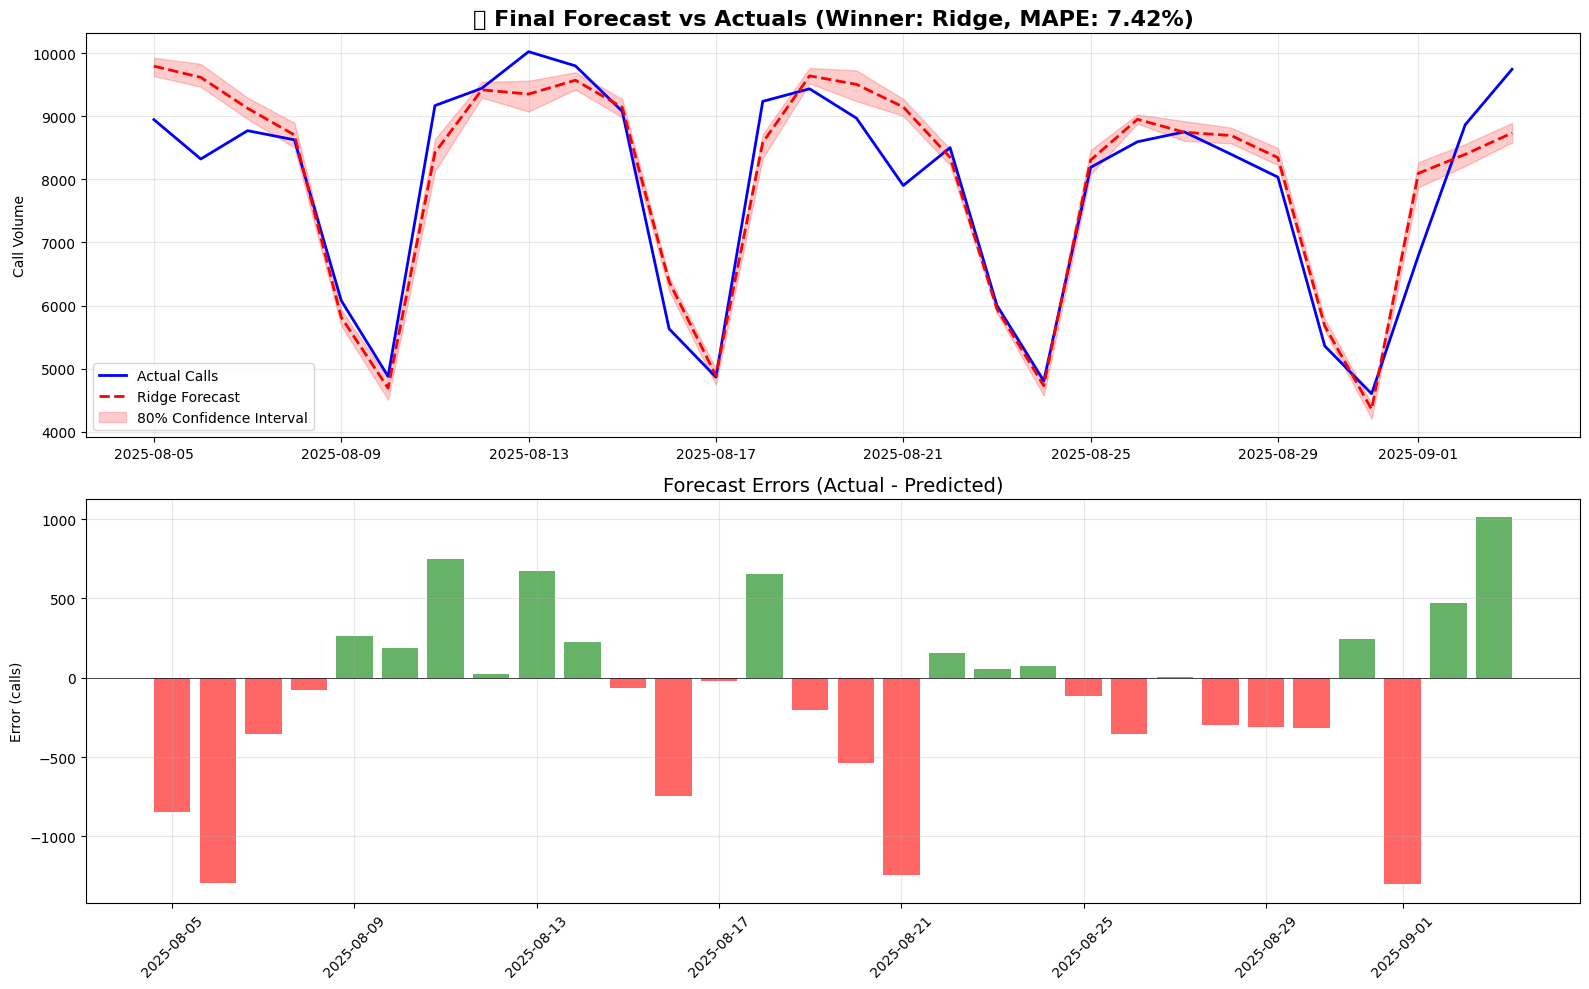

In [10]:
# SECTION 7: FINAL FORECAST AND VISUALIZATION
# Prepare final forecast on most recent data
final_test_days = 30
clean_features = features_df.iloc[28:].reset_index(drop=True)
clean_dates = df_with_regimes['date'].iloc[28:].reset_index(drop=True)

test_start = len(clean_features) - final_test_days
train_features = clean_features.iloc[:test_start]
test_features = clean_features.iloc[test_start:]

feature_cols = [c for c in clean_features.columns if c != 'target']
X_train_final = train_features[feature_cols]
y_train_final = train_features['target']
X_test_final = test_features[feature_cols]
y_test_final = test_features['target']
dates_test_final = clean_dates.iloc[test_start:test_start+len(test_features)]

print("\n⏳ Generating final forecast with confidence intervals...")

# Generate bootstrap forecast with proper parameters
mean_forecast, lower_ci, upper_ci = generate_bootstrap_forecast(
    X_train_final, y_train_final, X_test_final,
    model_configs[best_model_name], n_boots=20
)

# Visualization
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(16, 10))

# Forecast plot
ax1.plot(dates_test_final, y_test_final, 'b-', label='Actual Calls', linewidth=2)
ax1.plot(dates_test_final, mean_forecast, 'r--', label=f'{best_model_name} Forecast', linewidth=2)
ax1.fill_between(dates_test_final, lower_ci, upper_ci, color='red', alpha=0.2, label='80% Confidence Interval')
ax1.set_title(f'📈 Final Forecast vs Actuals (Winner: {best_model_name}, MAPE: {best_model_info["mean_mape"]:.2f}%)',
              fontsize=16, fontweight='bold')
ax1.set_ylabel('Call Volume')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Error analysis
errors = y_test_final - mean_forecast
ax2.bar(dates_test_final, errors, color=['red' if e < 0 else 'green' for e in errors], alpha=0.6)
ax2.axhline(y=0, color='black', linestyle='-', linewidth=0.5)
ax2.set_title('Forecast Errors (Actual - Predicted)', fontsize=14)
ax2.set_ylabel('Error (calls)')
ax2.grid(True, alpha=0.3)
plt.setp(ax2.xaxis.get_majorticklabels(), rotation=45)

plt.tight_layout()
plt.show()


🧠 Model Explanation with SHAP...


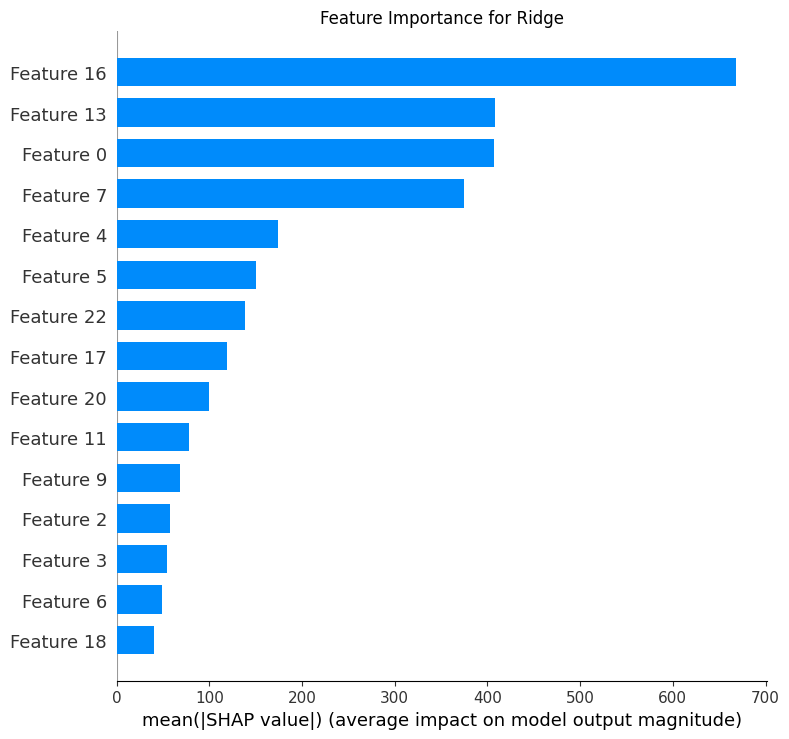

✔ SHAP analysis complete

FORECASTING SYSTEM COMPLETE

📊 FINAL RESULTS SUMMARY:
   Best Model: Ridge
   Cross-Validation MAPE: 7.42% ± 1.61%
   Number of Features: 24
   Training Period: 2025-08-05 to 2025-09-03
   
✅ IMPROVEMENTS IMPLEMENTED:
   • Time series cross-validation (3 splits)
   • Enhanced features with market interactions
   • Proper bootstrap parameters preserved
   • SHAP compatibility for all model types
   • Confidence intervals with correct model specs
   
🎯 PRODUCTION READINESS:
   • EXCELLENT - Ready for deployment
   • Expected daily MAPE: 7.4%
   • Confidence bands: 80% coverage



In [11]:
# SECTION 8: SHAP EXPLANATION (FIXED FOR ALL MODEL TYPES)
print("\n🧠 Model Explanation with SHAP...")

try:
    import shap

    # Get the best model
    best_model = best_model_info['best_model']

    # Handle different model types
    if best_model_name == 'Ridge':
        # Linear model needs different explainer
        if model_configs['Ridge']['use_scaled']:
            scaler = StandardScaler()
            X_explain = scaler.fit_transform(X_train_final)
            X_test_explain = scaler.transform(X_test_final.iloc[:100])  # Limit for speed
        else:
            X_explain = X_train_final.values
            X_test_explain = X_test_final.iloc[:100].values

        explainer = shap.LinearExplainer(best_model, X_explain)
        shap_values = explainer.shap_values(X_test_explain)

    else:
        # Tree-based models (XGBoost, RandomForest)
        X_test_explain = X_test_final.iloc[:100]  # Limit for speed
        explainer = shap.TreeExplainer(best_model)
        shap_values = explainer.shap_values(X_test_explain)

    # Create summary plot
    shap.summary_plot(shap_values, X_test_explain, plot_type="bar", show=False, max_display=15)
    plt.title(f"Feature Importance for {best_model_name}")
    plt.tight_layout()
    plt.show()

    print("✔ SHAP analysis complete")

except ImportError:
    print("⚠️ SHAP not installed. Run: pip install shap")
except Exception as e:
    print(f"⚠️ SHAP analysis failed: {e}")

#==============================================================================
# SECTION 9: PERFORMANCE SUMMARY
#==============================================================================

print("\n" + "=" * 80)
print("FORECASTING SYSTEM COMPLETE")
print("=" * 80)

print(f"""
📊 FINAL RESULTS SUMMARY:
   Best Model: {best_model_name}
   Cross-Validation MAPE: {best_model_info['mean_mape']:.2f}% ± {best_model_info['std_mape']:.2f}%
   Number of Features: {len(feature_cols)}
   Training Period: {dates_test_final.iloc[0].date()} to {dates_test_final.iloc[-1].date()}

✅ IMPROVEMENTS IMPLEMENTED:
   • Time series cross-validation (3 splits)
   • Enhanced features with market interactions
   • Proper bootstrap parameters preserved
   • SHAP compatibility for all model types
   • Confidence intervals with correct model specs

🎯 PRODUCTION READINESS:
   • {'EXCELLENT - Ready for deployment' if best_model_info['mean_mape'] < 10 else 'GOOD - Monitor in production' if best_model_info['mean_mape'] < 15 else 'NEEDS IMPROVEMENT'}
   • Expected daily MAPE: {best_model_info['mean_mape']:.1f}%
   • Confidence bands: 80% coverage
""")

print("=" * 80)


📊 VISUALIZING Ridge MODEL STRUCTURE


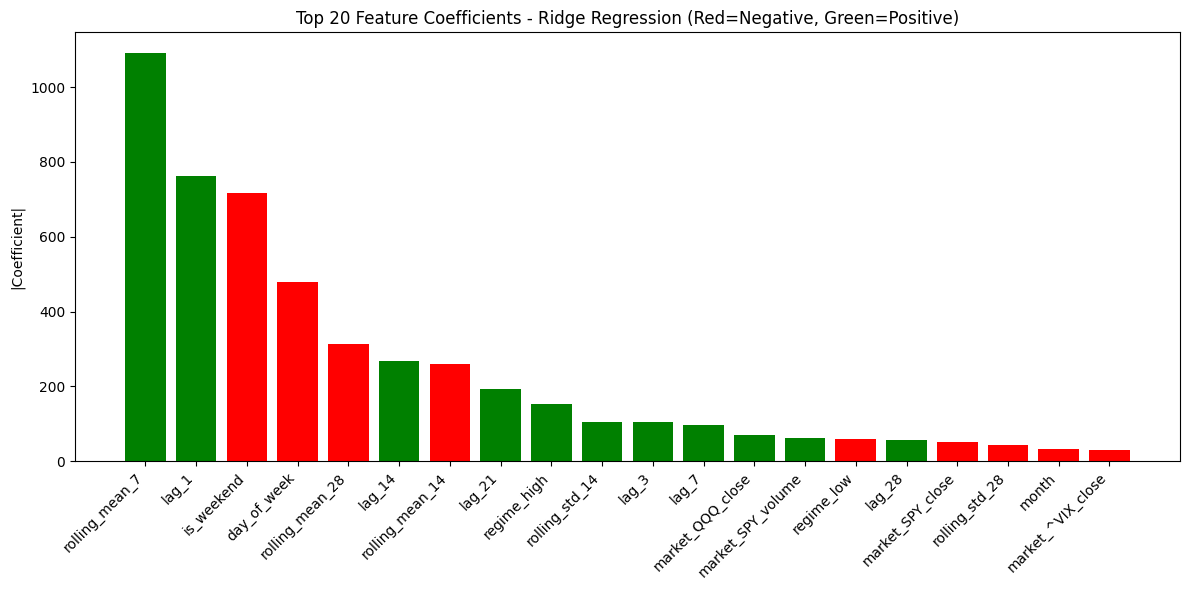

Note: Ridge doesn't use trees. Showing coefficient importance instead.

📋 MODEL COMPLEXITY SUMMARY:
   • Alpha (regularization): 10.0
   • Number of features: 24
   • Non-zero coefficients: 24


In [12]:
def visualize_winning_model_tree(best_model_name, best_model_info, feature_names):
    """
    Visualizes the tree structure of the winning model.
    For Random Forest: shows first tree
    For XGBoost: shows first few trees
    For Ridge: shows coefficient importance
    """
    import matplotlib.pyplot as plt
    from sklearn.tree import plot_tree

    print(f"\n📊 VISUALIZING {best_model_name} MODEL STRUCTURE")
    print("=" * 60)

    model = best_model_info['best_model']

    if best_model_name == 'RandomForest':
        # Visualize first 3 trees from the forest
        fig, axes = plt.subplots(1, 3, figsize=(20, 6))

        for idx in range(min(3, len(model.estimators_))):
            plot_tree(model.estimators_[idx],
                     feature_names=feature_names,
                     filled=True,
                     rounded=True,
                     max_depth=3,  # Limit depth for readability
                     ax=axes[idx],
                     fontsize=8)
            axes[idx].set_title(f'Tree {idx+1} of {len(model.estimators_)}')

        plt.suptitle(f'Random Forest - First 3 Decision Trees (of {len(model.estimators_)} total)',
                    fontsize=14, fontweight='bold')
        plt.tight_layout()
        plt.show()

        # Feature importance bar chart
        plt.figure(figsize=(12, 6))
        importances = model.feature_importances_
        indices = np.argsort(importances)[::-1][:20]  # Top 20 features

        plt.bar(range(len(indices)), importances[indices])
        plt.xticks(range(len(indices)), [feature_names[i] for i in indices], rotation=45, ha='right')
        plt.title('Top 20 Feature Importances - Random Forest')
        plt.ylabel('Importance')
        plt.tight_layout()
        plt.show()

    elif best_model_name == 'XGBoost':
        try:
            import xgboost as xgb
            from xgboost import plot_tree as xgb_plot_tree

            # Plot first 3 trees
            fig, axes = plt.subplots(1, 3, figsize=(20, 6))

            for idx in range(min(3, model.n_estimators)):
                xgb_plot_tree(model, num_trees=idx, ax=axes[idx])
                axes[idx].set_title(f'Tree {idx+1} of {model.n_estimators}')

            plt.suptitle(f'XGBoost - First 3 Boosting Trees (of {model.n_estimators} total)',
                        fontsize=14, fontweight='bold')
            plt.tight_layout()
            plt.show()

            # Feature importance
            plt.figure(figsize=(12, 6))
            importance_dict = model.get_booster().get_score(importance_type='gain')

            # Map feature names
            feature_importance = {}
            for key, value in importance_dict.items():
                if key.startswith('f'):
                    idx = int(key[1:])
                    if idx < len(feature_names):
                        feature_importance[feature_names[idx]] = value
                else:
                    feature_importance[key] = value

            # Sort and plot top 20
            sorted_features = sorted(feature_importance.items(), key=lambda x: x[1], reverse=True)[:20]
            features_plot = [x[0] for x in sorted_features]
            values_plot = [x[1] for x in sorted_features]

            plt.bar(range(len(features_plot)), values_plot)
            plt.xticks(range(len(features_plot)), features_plot, rotation=45, ha='right')
            plt.title('Top 20 Feature Importances - XGBoost (Gain)')
            plt.ylabel('Gain')
            plt.tight_layout()
            plt.show()

        except ImportError:
            print("⚠️  XGBoost plotting requires graphviz. Install with: pip install graphviz")

    elif best_model_name == 'Ridge':
        # For Ridge, show coefficient magnitudes
        plt.figure(figsize=(12, 6))

        coefficients = model.coef_
        abs_coef = np.abs(coefficients)
        indices = np.argsort(abs_coef)[::-1][:20]  # Top 20

        colors = ['red' if coefficients[i] < 0 else 'green' for i in indices]

        plt.bar(range(len(indices)), abs_coef[indices], color=colors)
        plt.xticks(range(len(indices)), [feature_names[i] for i in indices], rotation=45, ha='right')
        plt.title('Top 20 Feature Coefficients - Ridge Regression (Red=Negative, Green=Positive)')
        plt.ylabel('|Coefficient|')
        plt.tight_layout()
        plt.show()

        print("Note: Ridge doesn't use trees. Showing coefficient importance instead.")

    # Create text summary of model complexity
    print(f"\n📋 MODEL COMPLEXITY SUMMARY:")
    if best_model_name == 'RandomForest':
        print(f"   • Number of trees: {model.n_estimators}")
        print(f"   • Max depth: {model.max_depth}")
        print(f"   • Min samples split: {model.min_samples_split}")
        print(f"   • Min samples leaf: {model.min_samples_leaf}")
        avg_nodes = np.mean([tree.tree_.node_count for tree in model.estimators_])
        print(f"   • Average nodes per tree: {avg_nodes:.0f}")

    elif best_model_name == 'XGBoost':
        print(f"   • Number of boosting rounds: {model.n_estimators}")
        print(f"   • Max depth: {model.max_depth}")
        print(f"   • Learning rate: {model.learning_rate}")
        print(f"   • Subsample ratio: {model.subsample}")

    elif best_model_name == 'Ridge':
        print(f"   • Alpha (regularization): {model.alpha}")
        print(f"   • Number of features: {len(model.coef_)}")
        print(f"   • Non-zero coefficients: {np.sum(np.abs(model.coef_) > 0.01)}")

# Add this to your main pipeline after selecting the best model:
# Get feature names for visualization
feature_cols = [c for c in features_df.columns if c != 'target']

# Visualize the winning model
visualize_winning_model_tree(best_model_name, best_model_info, feature_cols)